In [1]:
import ee
import geemap
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [2]:
ee.Authenticate()
ee.Initialize(project='Indices_1')

In [3]:
# Define the region of interest
roi = ee.Geometry.Polygon(
    [[[82.81869989213432, 25.501659001310603],
      [82.93277481519623, 25.519530573013405],
      [82.84031129634387, 25.449173196897767],
      [82.85300070832785, 25.43040839570345]]])

# Function to mask clouds
def mask_s2_clouds(image):
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = qa.bitwiseAnd(cloud_bit_mask).eq(0) \
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    return image.updateMask(mask).divide(10000).copyProperties(image, ["system:time_start"])

In [4]:
# Function to calculate indices

def add_indices(image):
    # Calculate NDVI
    ndvi = image.normalizedDifference(['B8', 'B4']).rename(['ndvi'])

    # Calculate EVI
    evi = image.expression(
        '2.5 * ((B8 - B4) / (B8 + 6 * B4 - 7.5 * B2 + 1))', {
            'B8': image.select('B8'),
            'B4': image.select('B4'),
            'B2': image.select('B2')
        }).rename('evi')

    # Calculate Moisture Stress Index
    moisture_stress_index = image.expression(
        'B11 / B8', {
            'B8': image.select('B8'),
            'B11': image.select('B11')
        }).rename('moisture_stress_index')

    return image.addBands([ndvi, evi, moisture_stress_index])

In [5]:
# Load and process the image collection
dataset = (ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(roi)
    .filterDate('2019-01-01', '2023-12-31')
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 20))
    .map(mask_s2_clouds)
    .map(add_indices))

In [6]:
# extract index values and return a feature with index values and date
def extract_indices(image):
    indices = image.reduceRegion(
        reducer=ee.Reducer.mean(), geometry=roi, scale=10, maxPixels=1e6,
        bestEffort=True
    )
    date = ee.Date(image.get('system:time_start')).format('YYYY-MM-dd')
    return ee.Feature(None, indices.set('date', date))

In [7]:
extracted_features = dataset.map(extract_indices).getInfo()
#print(extracted_features)

In [8]:
# Extraction of Date, NDVI, EVI, MOISTURE STRESS INDEX
ext_ind=[]

for i in range(len(extracted_features['features'])):
    ext_indices = {
        'date': extracted_features['features'][i]['properties']['date'],
        'evi': extracted_features['features'][i]['properties']['evi'],
        'moisture_stress_index': extracted_features['features'][i]['properties']['moisture_stress_index'],
        'ndvi': extracted_features['features'][i]['properties']['ndvi']
    }
    ext_ind.append(ext_indices)

#print(ext_ind)

In [9]:
#Conversion to Dataframe
df=pd.DataFrame(ext_ind)
df.head()

#df.info()


,date,evi,moisture_stress_index,ndvi
0,2019-01-01,0.324800,0.763040,0.348894
1,2019-01-06,0.368210,0.776144,0.443161
2,2019-01-11,0.427945,0.665305,0.500714
3,2019-01-16,0.435608,0.687845,0.539486
4,2019-01-21,0.423913,0.654421,0.524700


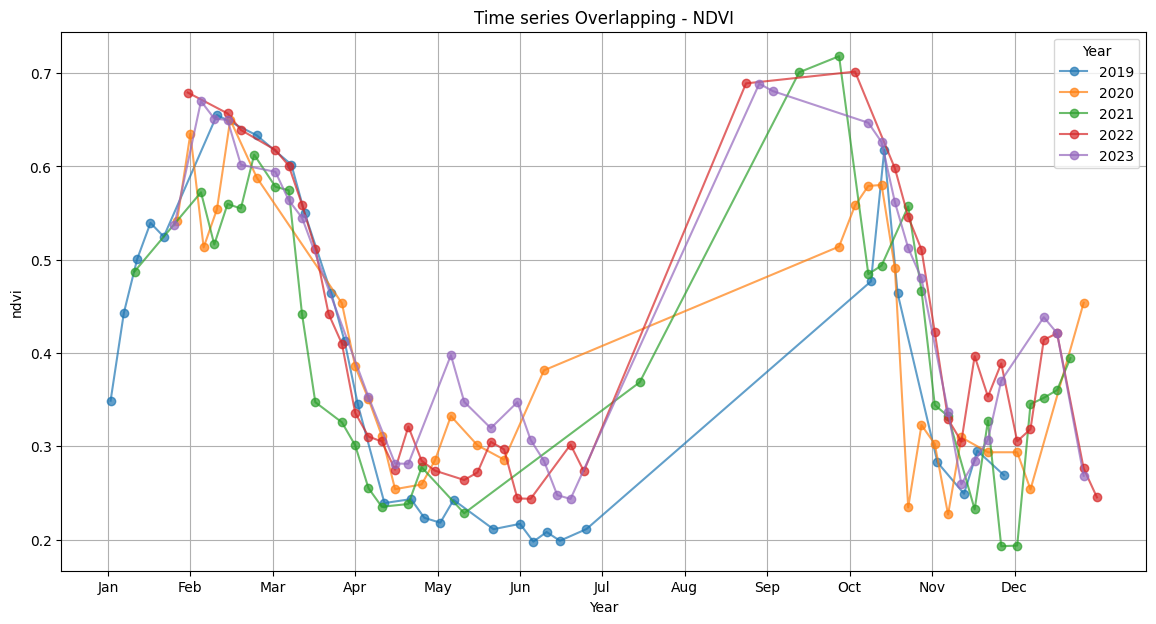

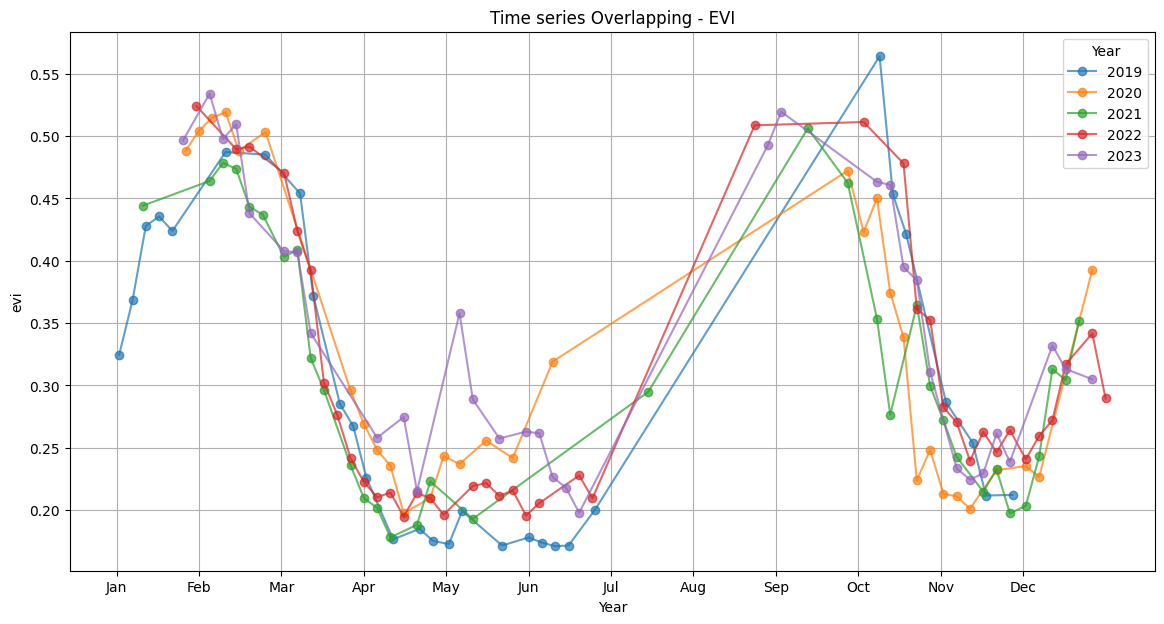

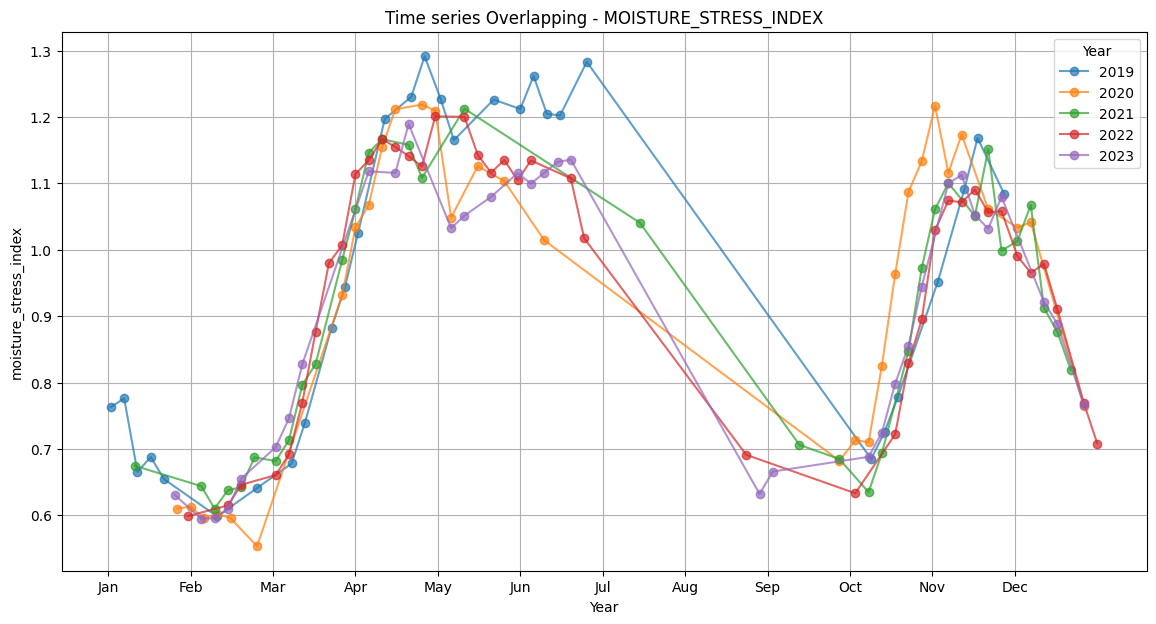

In [10]:
#Time-series plotting of indices
df['day'] = pd.to_datetime(df['date']).dt.day
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month

# Combine month and day into a decimal representation to plot accurately
df['month_day'] = df['month'] + df['day'] / 31.0
index_names = ['ndvi','evi', 'moisture_stress_index']

# Plot indices values for each year
for i in index_names:
  plt.figure(figsize=(14, 7))
  for year in df['year'].unique():
      year_data = df[df['year'] == year]
      plt.plot(year_data['month_day'], year_data[i], marker='o', linestyle='-', label=year, alpha=0.7)

  plt.xlabel('Year')
  plt.ylabel(i)
  plt.title(f'Time series Overlapping - {i.upper()}')
  plt.legend(title='Year')
  plt.xticks(ticks=np.arange(1, 13), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
  plt.grid(True)
  plt.show()